<a href="https://colab.research.google.com/github/zenon10/POC-OCR/blob/main/NER_bert_rg_202308.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## option 1
https://towardsdatascience.com/19-entities-for-104-languages-a-new-era-of-ner-with-the-deeppavlov-multilingual-bert-1bfa6d413ea6

In [ ]:
import sys
!{sys.executable} -m pip install --user deeppavlov

In [ ]:
!pip install pytorch-crf

In [ ]:
from torchcrf import CRF

In [ ]:
from deeppavlov import configs, build_model

ner_model = build_model(configs.ner.ner_ontonotes_bert_mult, download=True)

In [ ]:
ner_model(['Business Publications \n Le Contrat de Vente International '])

In [ ]:
ner_model(["Business Publications \n Le Contrat de Vente International est utilisé par des sociétés implantées dans différents pays pour la vente et l’achat de marchandises. L’exportateur (vendeur) s'engage à livrer certains produits et l’importateur (acheteur) s'engage à les acquérir dans les conditions de paiement" ])

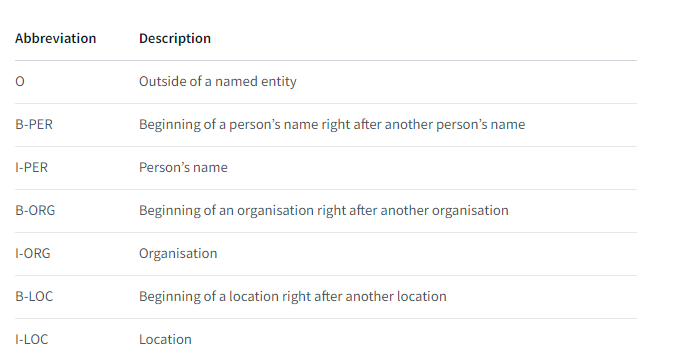

## Option 2
https://medium.com/@andrewmarmon/fine-tuned-named-entity-recognition-with-hugging-face-bert-d51d4cb3d7b5

In [ ]:
!git clone https://github.com/leslie-huang/UN-named-entity-recognition

Cloning into 'UN-named-entity-recognition'...
remote: Enumerating objects: 21580, done.
remote: Total 21580 (delta 0), reused 0 (delta 0), pack-reused 21580
Receiving objects: 100% (21580/21580), 14.70 MiB | 14.61 MiB/s, done.
Resolving deltas: 100% (21095/21095), done.


In [ ]:
directory= '/content/UN-named-entity-recognition/tagged-training'
df = pd.concat([get_tokens_and_ner_tags(os.path.join(directory, filename)) for filename in os.listdir(directory)]).reset_index().drop('index', axis=1)
df.head()

,tokens,ner_tags
0,"[Twenty-one, years, ago, ,, on, a, day, like, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
1,"[We, remember, the, victims, ,, and, we, expre...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]"
2,"[Madam, President, ,, on, behalf, of, Mexico, ...","[O, O, O, O, O, O, I-LOC, O, O, O, O, O, O, O,..."
3,"[We, wish, you, every, success, .]","[O, O, O, O, O, O]"
4,"[The, Mexican, people, thank, Mr., Jan, Eliass...","[O, O, O, O, O, I-PER, I-PER, O, O, O, O, O, I..."


In [ ]:
!pip install transformers
!pip install datasets
!pip install seqeval

In [ ]:
import os
import itertools
import pandas as pd
import numpy as np
from datasets import Dataset
from datasets import load_metric
from transformers import AutoTokenizer
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
import torch

label_list = ['O','B-MISC','I-MISC','B-PER','I-PER','B-ORG','I-ORG','B-LOC','I-LOC']
label_encoding_dict = {'I-PRG': 2,'I-I-MISC': 2, 'I-OR': 6, 'O': 0, 'I-': 0, 'VMISC': 0, 'B-PER': 3, 'I-PER': 4, 'B-ORG': 5, 'I-ORG': 6, 'B-LOC': 7, 'I-LOC': 8, 'B-MISC': 1, 'I-MISC': 2}

task = "ner" 
model_checkpoint = "distilbert-base-uncased"
batch_size = 16
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

def get_all_tokens_and_ner_tags(directory):
    return pd.concat([get_tokens_and_ner_tags(os.path.join(directory, filename)) for filename in os.listdir(directory)]).reset_index().drop('index', axis=1)
    
def get_tokens_and_ner_tags(filename):
    with open(filename, 'r', encoding="utf8") as f:
        lines = f.readlines()
        split_list = [list(y) for x, y in itertools.groupby(lines, lambda z: z == '\n') if not x]
        tokens = [[x.split('\t')[0] for x in y] for y in split_list]
        entities = [[x.split('\t')[1][:-1] for x in y] for y in split_list] 
    return pd.DataFrame({'tokens': tokens, 'ner_tags': entities})
  
def get_un_token_dataset(train_directory, test_directory):
    train_df = get_all_tokens_and_ner_tags(train_directory)
    test_df = get_all_tokens_and_ner_tags(test_directory)
    train_dataset = Dataset.from_pandas(train_df)
    test_dataset = Dataset.from_pandas(test_df)

    return (train_dataset, test_dataset)

train_dataset, test_dataset = get_un_token_dataset('./UN-named-entity-recognition/tagged-training/', './UN-named-entity-recognition/tagged-test/')

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.26.0",
  "vocab_size": 30522
}



loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/vocab.txt
loading file tokenizer.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer.json
loading file added_tokens.json from cache at None
loading file special_tokens_map.json from cache at None
loading file tokenizer_config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/tokenizer_config.json
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/1c4513b2eedbda136f57676a34eea67aba266e5c/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropo

In [ ]:
train_dataset

In [ ]:
def tokenize_and_align_labels(examples):
    label_all_tokens = True
    tokenized_inputs = tokenizer(list(examples["tokens"]), truncation=True, is_split_into_words=True)

    labels = []
    for i, label in enumerate(examples[f"{task}_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif label[word_idx] == '0':
                label_ids.append(0)
            elif word_idx != previous_word_idx:
                label_ids.append(label_encoding_dict[label[word_idx]])
            else:
                label_ids.append(label_encoding_dict[label[word_idx]] if label_all_tokens else -100)
            previous_word_idx = word_idx
        labels.append(label_ids)
        
    tokenized_inputs["labels"] = labels
    return tokenized_inputs


train_tokenized_datasets = train_dataset.map(tokenize_and_align_labels, batched=True)
test_tokenized_datasets = test_dataset.map(tokenize_and_align_labels, batched=True)

In [ ]:
train_tokenized_datasets

Each token has now been transformed into a numeric representation and each label has been mapped to those used in upstream training, all in Hugging Face data format.

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(label_list))

args = TrainingArguments(
    f"test-{task}",
    evaluation_strategy = "epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=1e-5,
)

data_collator = DataCollatorForTokenClassification(tokenizer)
metric = load_metric("seqeval")


def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [[label_list[p] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    true_labels = [[label_list[l] for (p, l) in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {"precision": results["overall_precision"], "recall": results["overall_recall"], "f1": results["overall_f1"], "accuracy": results["overall_accuracy"]}
    
trainer = Trainer(
    model,
    args,
    train_dataset=train_tokenized_datasets,
    eval_dataset=test_tokenized_datasets,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()
trainer.evaluate()
trainer.save_model('un-ner.model')

In [ ]:
!wandb login --relogin '929b46c4abde3e31a2efcf8ebb022177b97c80e1'

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('./un-ner.model/')

paragraph = '''Before proceeding further, I should like to inform members that action on draft resolution iv, entitled situation of human rights of Rohingya Muslims and other minorities in Myanmar is postponed to a later date to allow time for the review of its programme budget implications by the fifth committee. The assembly will take action on draft resolution iv as soon as the report of the fifth committee on the programme budget implications is available. I now give the floor to delegations wishing to deliver explanations of vote or position before voting or adoption.'''
tokens = tokenizer(paragraph)
torch.tensor(tokens['input_ids']).unsqueeze(0).size()

model = AutoModelForTokenClassification.from_pretrained('./un-ner.model/', num_labels=len(label_list))
preds = model.forward(input_ids=torch.tensor(tokens['input_ids']).unsqueeze(0), attention_mask=torch.tensor(tokens['attention_mask']).unsqueeze(0))
preds = torch.argmax(preds.logits.squeeze(), axis=1)
predictions = [label_list[i] for i in preds]

words = tokenizer.batch_decode(tokens['input_ids'])
pd.DataFrame({'ner': predictions, 'words': words}).to_csv('un_ner.csv')

## option 3
https://www.analyticsvidhya.com/blog/2022/06/fine-tune-bert-model-for-named-entity-recognition-in-google-colab/

In [ ]:
!pip install datasets -q
!pip install tokenizers -q
!pip install transformers -q
!pip install seqeval -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
from datasets import load_dataset

dataset = load_dataset("wikiann", "fr")

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/fr/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
label_names = dataset["train"].features["ner_tags"].feature.names
label_names

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

In [ ]:
type(dataset['train'])

datasets.arrow_dataset.Dataset

In [ ]:
dataset.column_names

{'validation': ['tokens', 'ner_tags', 'langs', 'spans'],
 'test': ['tokens', 'ner_tags', 'langs', 'spans'],
 'train': ['tokens', 'ner_tags', 'langs', 'spans']}

https://huggingface.co/datasets/wikiann/viewer/fr/train


In [ ]:
dataset['train'][:2]

{'tokens': [['Saxifrage', 'faux', 'Orpin'],
  ['REDIRECTION', 'The', 'Lady', 'of', 'Rage']],
 'ner_tags': [[5, 6, 6], [0, 1, 2, 2, 2]],
 'langs': [['fr', 'fr', 'fr'], ['fr', 'fr', 'fr', 'fr', 'fr']],
 'spans': [['LOC: Saxifrage faux Orpin'], ['PER: The Lady of Rage']]}

In [ ]:
dataset['validation'][0]

{'tokens': ['145', ',', '118', ',', '102', 'Stephen', 'Maguire'],
 'ner_tags': [0, 0, 0, 0, 0, 1, 2],
 'langs': ['fr', 'fr', 'fr', 'fr', 'fr', 'fr', 'fr'],
 'spans': ['PER: Stephen Maguire']}

Data Preprocessing
- Bert expects input in input_ids, token_type_ids and attention_mask format
- The label also requires adjustment due to subword tokenization used by BERT

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["tokens"], padding="max_length", truncation=True, is_split_into_words=True)

In [ ]:
tokenized_datasets_ = dataset.map(tokenize_function, batched=True)

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

In [ ]:
tokenized_datasets_['train'][0]['input_ids'][:20]

[101,
 12404,
 20572,
 59634,
 82568,
 19372,
 17298,
 102,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [ ]:
tokenized_datasets_['train'][0]['ner_tags'][:20]

[5, 6, 6]

In [ ]:
len(tokenized_datasets_['train'][0]['input_ids']) == len(tokenized_datasets_['train'][0]['ner_tags'])

False

In [ ]:
'''We can see that len of input_ids is not matching with ner_tags that's why we require to adjust 
  the labels according to the tokenized output.
  We will use the argument truncation=True (to truncate texts that are bigger than the maximum size 
  allowed by the model) as there is a sequence in data which has length>512'''

#Get the values for input_ids, attention_mask, adjusted labels
def tokenize_adjust_labels(all_samples_per_split):
  tokenized_samples = tokenizer.batch_encode_plus(all_samples_per_split["tokens"], is_split_into_words=True, truncation=True)
  
  total_adjusted_labels = []
  
  for k in range(0, len(tokenized_samples["input_ids"])):
    prev_wid = -1
    word_ids_list = tokenized_samples.word_ids(batch_index=k)
    existing_label_ids = all_samples_per_split["ner_tags"][k]
    i = -1
    adjusted_label_ids = []
   
    for word_idx in word_ids_list:
      # Special tokens have a word id that is None. We set the label to -100 so they are automatically
      # ignored in the loss function.
      if(word_idx is None):
        adjusted_label_ids.append(-100)
      elif(word_idx!=prev_wid):
        i = i + 1
        adjusted_label_ids.append(existing_label_ids[i])
        prev_wid = word_idx
      else:
        label_name = label_names[existing_label_ids[i]]
        adjusted_label_ids.append(existing_label_ids[i])
        
    total_adjusted_labels.append(adjusted_label_ids)
  
  #add adjusted labels to the tokenized samples
  tokenized_samples["labels"] = total_adjusted_labels
  return tokenized_samples

tokenized_dataset = dataset.map(tokenize_adjust_labels, batched=True, remove_columns=['tokens', 'ner_tags', 'langs', 'spans'])

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/10 [00:00<?, ?ba/s]

  0%|          | 0/20 [00:00<?, ?ba/s]

In [ ]:
out = tokenizer("Contrat de Vente International prêt à l'emploi")
out

{'input_ids': [101, 62046, 10123, 10104, 19561, 11227, 10771, 95412, 254, 180, 112, 41305, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
out.word_ids(0)

[None, 0, 0, 1, 2, 2, 3, 4, 5, 6, 7, 8, None]

In [ ]:
tokenized_dataset

DatasetDict({
    validation: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 20000
    })
})

In [ ]:
tokenized_dataset['train'][:2]

{'input_ids': [[101, 12404, 20572, 59634, 82568, 19372, 17298, 102],
  [101, 71033, 58730, 66014, 91995, 52980, 10117, 14005, 10108, 65676, 102]],
 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1],
  [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]],
 'labels': [[-100, 5, 5, 5, 6, 6, 6, -100],
  [-100, 0, 0, 0, 0, 0, 1, 2, 2, 2, -100]]}

In [ ]:
from transformers import DataCollatorForTokenClassification
data_collator = DataCollatorForTokenClassification(tokenizer)

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import AutoModelForTokenClassification, AdamW

In [ ]:
#check if gpu is present
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [ ]:
model = AutoModelForTokenClassification.from_pretrained("bert-base-multilingual-cased", num_labels=len(label_names))
model.to(device)

In [ ]:
import numpy as np
from datasets import load_metric
metric = load_metric("seqeval")

def compute_metrics(p):
    predictions, labels = p

    #select predicted index with maximum logit for each token
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

<ipython-input-27-02b457ce3401>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("seqeval")


In [ ]:
example = dataset["train"][1]
labels = [label_names[i] for i in example[f"ner_tags"]]
metric.compute(predictions=[labels], references=[labels])
labels

['O', 'B-PER', 'I-PER', 'I-PER', 'I-PER']

In [ ]:
dataset["train"][1]

{'tokens': ['REDIRECTION', 'The', 'Lady', 'of', 'Rage'],
 'ner_tags': [0, 1, 2, 2, 2],
 'langs': ['fr', 'fr', 'fr', 'fr', 'fr'],
 'spans': ['PER: The Lady of Rage']}

In [ ]:
from transformers import TrainingArguments, Trainer

batch_size = 16
logging_steps = len(tokenized_dataset['train']) // batch_size
epochs = 2

training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert-fine-tune-ner/results",
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    evaluation_strategy="epoch",
    disable_tqdm=False,
    logging_steps=logging_steps)

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

#fine tune using train method
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 20000
  Num Epochs = 2
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2500
  Number of trainable parameters = 177268231
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.295500,0.207781,0.877187,0.891078,0.884078,0.941272
2,0.136900,0.193026,0.894644,0.908490,0.901513,0.948893


Saving model checkpoint to /content/drive/MyDrive/bert-fine-tune-ner/results/checkpoint-500
Configuration saved in /content/drive/MyDrive/bert-fine-tune-ner/results/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/bert-fine-tune-ner/results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/bert-fine-tune-ner/results/checkpoint-500/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/bert-fine-tune-ner/results/checkpoint-500/special_tokens_map.json
Saving model checkpoint to /content/drive/MyDrive/bert-fine-tune-ner/results/checkpoint-1000
Configuration saved in /content/drive/MyDrive/bert-fine-tune-ner/results/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/bert-fine-tune-ner/results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /content/drive/MyDrive/bert-fine-tune-ner/results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /content/drive/My

TrainOutput(global_step=2500, training_loss=0.21617548217773438, metrics={'train_runtime': 489.579, 'train_samples_per_second': 81.703, 'train_steps_per_second': 5.106, 'total_flos': 569930319849792.0, 'train_loss': 0.21617548217773438, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 10000
  Batch size = 16


{'eval_loss': 0.19302591681480408,
 'eval_precision': 0.8946435691816933,
 'eval_recall': 0.9084896747199352,
 'eval_f1': 0.9015134604223403,
 'eval_accuracy': 0.9488929171372441,
 'eval_runtime': 24.9314,
 'eval_samples_per_second': 401.1,
 'eval_steps_per_second': 25.069,
 'epoch': 2.0}

In [ ]:
predictions, labels, _ = trainer.predict(tokenized_dataset["test"])
predictions = np.argmax(predictions, axis=2)
# Remove ignored index (special tokens)
true_predictions = [
    [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
true_labels = [
    [label_names[l] for (p, l) in zip(prediction, label) if l != -100]
    for prediction, label in zip(predictions, labels)
]
results = metric.compute(predictions=true_predictions, references=true_labels)
results

***** Running Prediction *****
  Num examples = 10000
  Batch size = 16


{'LOC': {'precision': 0.9015423242467718,
  'recall': 0.9376981906360754,
  'f1': 0.9192648806802597,
  'number': 10722},
 'ORG': {'precision': 0.8400900900900901,
  'recall': 0.8438914027149321,
  'f1': 0.8419864559819412,
  'number': 5746},
 'PER': {'precision': 0.9415563957151859,
  'recall': 0.9305620426591935,
  'f1': 0.936026936026936,
  'number': 6423},
 'overall_precision': 0.8972155379855621,
 'overall_recall': 0.9121488794722817,
 'overall_f1': 0.9046205835842559,
 'overall_accuracy': 0.948153429077981}

In [ ]:
tokenized_dataset["test"][0]

{'input_ids': [101,
  112,
  112,
  112,
  13656,
  11183,
  11239,
  112,
  112,
  112,
  113,
  11419,
  10451,
  14971,
  114,
  102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 0, 0, 0, 3, 3, 4, 0, 0, 0, 0, 0, 0, 0, 0, -100]}

In [ ]:
out = tokenizer("Le Contrat de Vente International est utilisé par des sociétés implantées dans différents pays pour la vente et l’achat de marchandises. L’exportateur (vendeur) s'engage à livrer certains produits et l’importateur (acheteur) s'engage à les acquérir dans les conditions de paiement et de livraison et dans les délais convenus. Ce Contrat sert à la vente internationale de divers types de produits (matières premières, composants industriels, biens de consommation")
out.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
trainer.predict(out)
predictions = np.argmax(predictions, axis=2)

***** Running Prediction *****
  Num examples = 3
  Batch size = 16


IndexError: ignored

## flair

In [ ]:
!pip install flair

from flair.data import Sentence
from flair.models import SequenceTagger

# load tagger
tagger = SequenceTagger.load("flair/ner-french")

# make example sentence
sentence = Sentence("George Washington est allé à Washington")

# predict NER tags
tagger.predict(sentence)

# print sentence
print(sentence)

# print predicted NER spans
print('The following NER tags are found:')
# iterate over entities and print
for entity in sentence.get_spans('ner'):
    print(entity)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.9/401.9 KB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 788.5/788.5 KB 59.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 KB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.7/19.7 MB 79.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 64.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 62.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.5/200.5 KB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for mpld3: filename=mpld3-0.3-py3-non

/usr/local/lib/python3.8/dist-packages/huggingface_hub/file_download.py:629: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  warnings.warn(


2023-02-08 09:05:40,436 loading file /root/.flair/models/ner-french/7363c68d2342aef796cf73c7a5a598c2786b051a5bcbd1152d32e6a100b63ce9.203314314706e4ef730093277621572fc37d926fdf95f0c7623c840ff4ac664c
2023-02-08 09:05:48,643 SequenceTagger predicts: Dictionary with 20 tags: <unk>, O, B-LOC, E-LOC, S-LOC, B-MISC, E-MISC, B-PER, E-PER, S-PER, I-MISC, I-PER, I-LOC, S-MISC, B-ORG, E-ORG, I-ORG, S-ORG, <START>, <STOP>
Sentence: "George Washington est allé à Washington" → ["George Washington"/PER, "Washington"/LOC]
The following NER tags are found:
Span[0:2]: "George Washington" → PER (0.7394)
Span[5:6]: "Washington" → LOC (0.9161)


In [ ]:
from flair.data import Corpus
from flair.datasets import WIKINER_FRENCH
from flair.embeddings import WordEmbeddings, StackedEmbeddings, FlairEmbeddings

# 1. get the corpus
corpus: Corpus = WIKINER_FRENCH()

# 2. what tag do we want to predict?
tag_type = 'ner'

# 3. make the tag dictionary from the corpus
tag_dictionary = corpus.make_tag_dictionary(tag_type=tag_type)

# 4. initialize each embedding we use
embedding_types = [

    # GloVe embeddings
    WordEmbeddings('fr'),

    # contextual string embeddings, forward
    FlairEmbeddings('fr-forward'),

    # contextual string embeddings, backward
    FlairEmbeddings('fr-backward'),
]

# embedding stack consists of Flair and GloVe embeddings
embeddings = StackedEmbeddings(embeddings=embedding_types)

# 5. initialize sequence tagger
from flair.models import SequenceTagger

tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=tag_dictionary,
                        tag_type=tag_type)

# 6. initialize trainer
from flair.trainers import ModelTrainer

trainer = ModelTrainer(tagger, corpus)

# 7. run training
trainer.train('resources/taggers/ner-french',
              train_with_dev=True,
              max_epochs=150)

ImportError: ignored